In [27]:
from glob import iglob
from datetime import datetime
from itertools import chain, repeat
from os.path import basename, exists
from pickle import load, dump

import numpy as np
import pandas as pd
from cytoolz import compose, reduce
from h5py import File
from dask import delayed, compute
from dask.bag import from_sequence
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

In [28]:
def is_available(filename):
    if filename.endswith("_0.h5"):
        return False
    try:
        with File(filename, 'r'):
            pass
        return True
    except Exception:
        return False


def read_wavelength_at_max(filename: str):
    with File(filename, "r") as f:
        try:
            x0 = 500
            x1 = f["/photon_diagnostics/Spectrometer/Wavelength"][...]
            a = (
                f["/photon_diagnostics/Spectrometer/WavelengthSpan"][...]
                * f["/photon_diagnostics/Spectrometer/Pixel2micron"][...]
                / 1000
            )
            arr = f["/photon_diagnostics/Spectrometer/hor_spectrum"][...]
            _, n = arr.shape
            x = a * (np.arange(n) - x0) + x1
            for tag, y in zip(f['/bunches'], arr):
                yield {"tag": tag, "atmax": x[np.argmax(y)]}
        except KeyError:
            return


def read_tof(filename):
    with File(filename, 'r') as f:
        try:
            yield from ({'tag': tag,
                         'tof': tof.astype('double')}
                        for tag, tof
                        in zip(f['/bunches'],
                               f['/digitizer/channel1']))
        except KeyError:
            return

In [29]:
runs = [190]
globbed = chain.from_iterable(iglob(f"/data/*/Run_{r:03d}/rawdata/*.h5") for r in runs)
filenames = sorted(fn for fn in set(globbed) if is_available(fn))
bg_period, bg_mod = 3, 0  # /Background_Period

In [30]:
integ = (
    from_sequence(filenames)
    .topk(10)  # limit the number of files to be read
    .map(read_tof)
    .flatten()
    .to_dataframe()
)
integ['is_bg'] = integ['tag'] % bg_period == bg_mod

with ProgressBar():
    summed = compute(
        *[
            {
                'is_bg': bg,
                'count': delayed(integ[integ['is_bg'] == bg]['tof'].to_bag().count()),
                'summed': delayed(integ[integ['is_bg'] == bg]['tof'].to_bag().sum()),
            }
            for bg in [True, False]
        ],
    )

summed = pd.DataFrame(list(summed)).set_index('is_bg')
summed

[########################################] | 100% Completed |  1.3s


,count,summed
is_bg,,
True,301,"[133138.0, 133130.0, 133138.0, 133147.0, 13313..."
False,603,"[266720.0, 266739.0, 266730.0, 266711.0, 26672..."


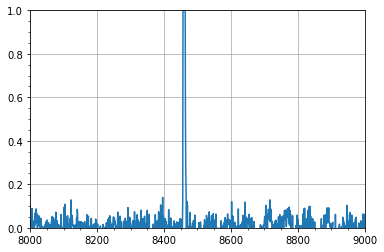

In [31]:
avg = (
    summed.loc[False, 'summed'] / summed.loc[False, 'count']
    - summed.loc[True, 'summed'] / summed.loc[True, 'count']
)
plt.plot(-avg)
plt.xlim(8000, 9000)
plt.ylim(0, 1)
plt.minorticks_on()
plt.grid(True)
plt.show()

In [32]:
def read_scala(filename):
    with File(filename, 'r') as f:
        try:
            x0 = 500
            x1 = f["/photon_diagnostics/Spectrometer/Wavelength"][...]
            a = (
                f["/photon_diagnostics/Spectrometer/WavelengthSpan"][...]
                * f["/photon_diagnostics/Spectrometer/Pixel2micron"][...]
                / 1000
            )
            _, n = f["/photon_diagnostics/Spectrometer/hor_spectrum"].shape
            x = a * (np.arange(n) - x0) + x1

            yield from ({'tag': tag,
                         'iom_intensity_pc': iom,
                         'tof_intensity': tof[8400:8600].sum(),
                         'delay_float': dt,
                         'atmax': x[np.argmax(hor)]}
                        for tag, iom, tof, dt, hor
                        in zip(f['/bunches'],
                               f['/photon_diagnostics/FEL01/I0_monitor/iom_sh_a_pc'],
                               f['/digitizer/channel1'],
                               f['/user_laser/delay_line/position'],
                               f["/photon_diagnostics/Spectrometer/hor_spectrum"]))
        except KeyError:
            return


def read_from_cache(filename, rewrite=False):
    cache = f"../cache/{basename(filename)}.pickle"
    if exists(cache) and not rewrite:
        with open(cache, "br") as f:
            loaded = load(f)
    else:
        loaded = [v for v in read_scala(filename)]
        with open(cache, "bw") as f:
            dump(loaded, f)
    yield from loaded


with ProgressBar():
    df = (
        from_sequence(filenames)
        .map(read_from_cache)
        .flatten()
        .to_dataframe()
        .compute()
    )
df = df.set_index("tag").sort_index()
comb_width = 0.0318
df['is_bg'] = df.index % bg_period == bg_mod
df["phi_float"] = 1239.84193 / df["atmax"] % comb_width / comb_width * 2 * np.pi  # comb width in eV units


def binit(d):
    centers = np.arange(-10, 0, 0.025)
    bins = (centers[1:] + centers[:-1]) / 2
    return centers.item(np.digitize(d, bins=bins))


df["delay"] = df["delay_float"].apply(binit)
df

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  5.5s


,atmax,delay_float,iom_intensity_pc,tof_intensity,is_bg,phi_float,delay
tag,,,,,,,
485125850,50.578823,-6.779992,288.629723,88232,False,5.347467,-6.775
485125851,50.564395,-6.779992,284.951019,88482,True,0.446274,-6.775
485125852,50.561990,-6.779992,303.916168,88198,False,0.676682,-6.775
485125853,50.535539,-6.779992,283.622360,88283,False,3.212624,-6.775
485125854,50.521112,-6.779992,301.318932,88441,True,4.596985,-6.775
485125855,50.549967,-6.779992,322.318268,88204,False,1.829054,-6.775
485125856,50.566800,-6.779992,290.797806,88190,False,0.215887,-6.775
485125857,50.537944,-6.779992,286.314011,88483,True,2.981975,-6.775
485125858,50.566800,-6.779992,271.249008,88137,False,0.215887,-6.775


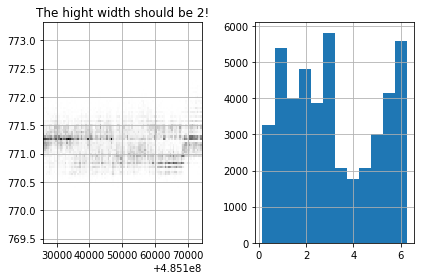

In [33]:
plt.figure()
plt.subplot(121)
plt.title("The hight width should be 2!")
# plt.hist2d(df.index, df['atmax'], bins=[100, 100], cmap="Greys")
plt.hist2d(df.index, 1239.84193 / df['atmax'] / comb_width, bins=[100, 100], cmap="Greys")
plt.grid(True)

plt.subplot(122)
plt.hist(df['phi_float'], bins=12)
plt.grid(True)
plt.tight_layout()
plt.show()

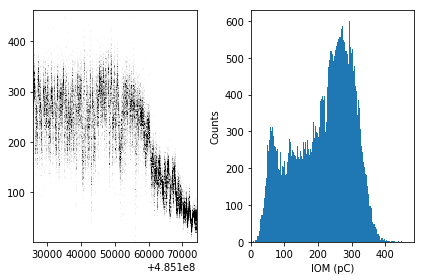

In [34]:
plt.figure()
plt.subplot(121)
plt.hist2d(df.index, df["iom_intensity_pc"], bins=[200, 200], cmap="Greys")
plt.clim(0, 1e1)
plt.subplot(122)
plt.hist(df["iom_intensity_pc"], bins=200)
plt.xlabel("IOM (pC)")
plt.ylabel("Counts")
plt.xlim(0, None)
plt.tight_layout()
plt.show()

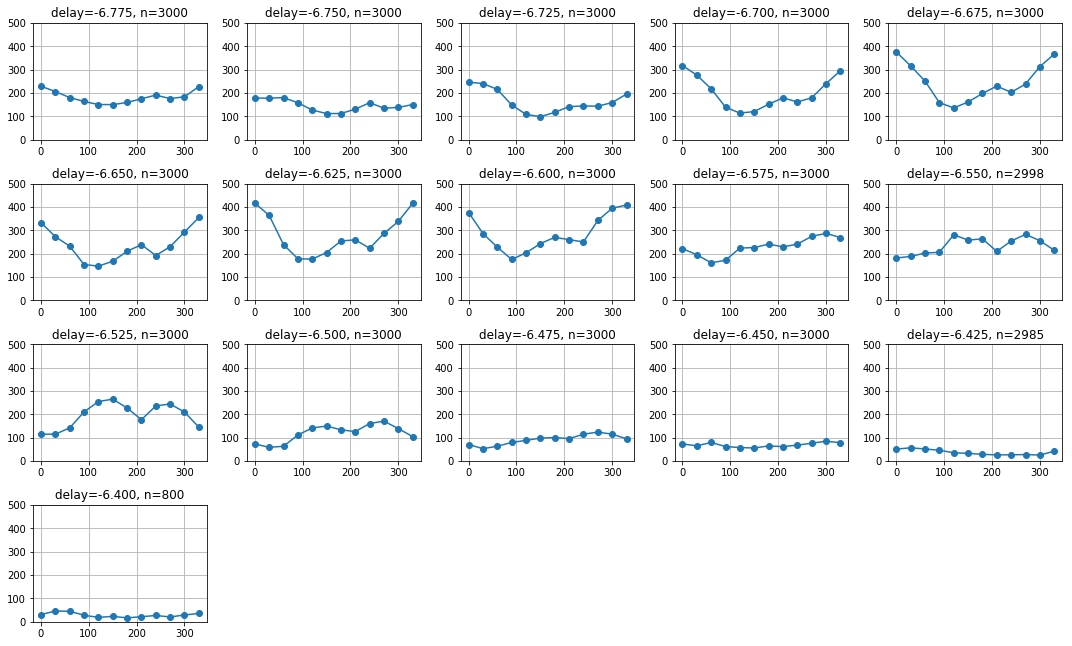

In [35]:
def binit(d):
    bins = np.linspace(0, 2 * np.pi, 12+1, endpoint=True)
    centers = bins
    return centers.item(np.digitize(d, bins=bins) - 1)


df["phi"] = df["phi_float"].apply(binit)

plt.figure(figsize=(15, 20))
for i, dt in enumerate(sorted(df["delay"].unique())):
    if -1 < dt:
        continue
    where = (
        (20 < df["iom_intensity_pc"])
        & (df['delay'] == dt)
    )
    plt.subplot(9, 5, i+1)
    groupped = df[where].groupby(['phi', 'is_bg'])['tof_intensity'].agg(['count', 'sum'])
    plt.title(f"delay={dt:.3f}, n={where.sum()}")
    diff = -(
        (groupped.loc[pd.IndexSlice[:, False], 'sum'] / groupped.loc[pd.IndexSlice[:, False], 'count'])
            .reset_index(level=[1], drop=True)
        - (groupped.loc[pd.IndexSlice[:, True], 'sum'] / groupped.loc[pd.IndexSlice[:, True], 'count'])
            .reset_index(level=[1], drop=True)
    )
    plt.plot(diff.index / np.pi * 180, diff, 'o-')
    plt.ylim(0, 500)
    plt.grid(True)
plt.tight_layout()
plt.show()

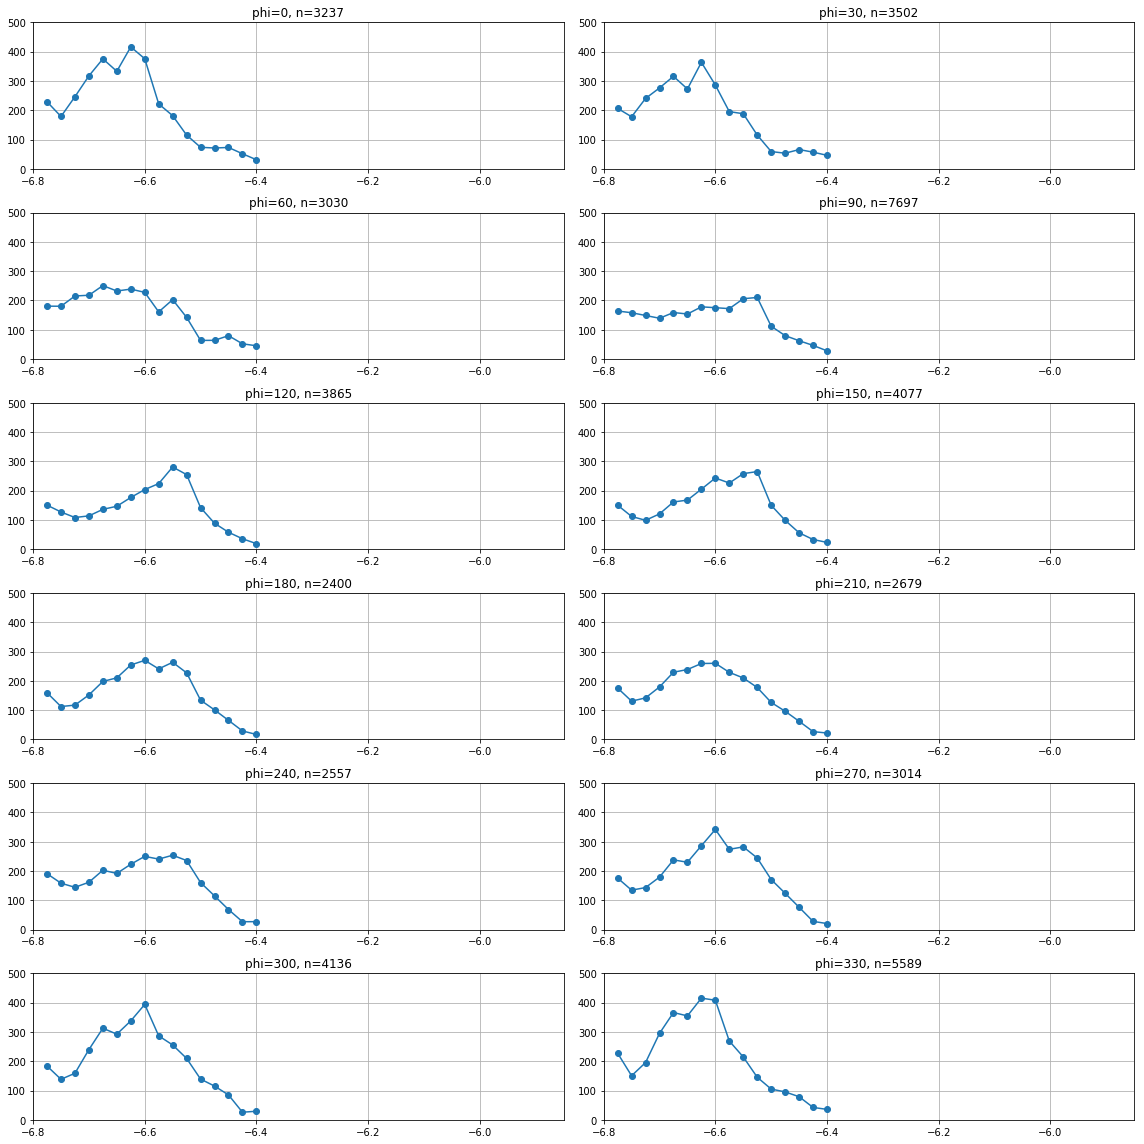

In [36]:
def binit(d):
    bins = np.linspace(0, 2 * np.pi, 12+1, endpoint=True)
    centers = bins
    return centers.item(np.digitize(d, bins=bins) - 1)


df["phi"] = df["phi_float"].apply(binit)

plt.figure(figsize=(16, 16))
for i, ph in enumerate(sorted(df["phi"].unique())):
    plt.subplot(6, 2, i+1)
    where = (
        (20 < df["iom_intensity_pc"])
        & 
        (df['phi'] == ph)
    )
    groupped = df[where].groupby(['delay', 'is_bg'])['tof_intensity'].agg(['count', 'sum'])
    plt.title(f"phi={ph/np.pi*180:.0f}, n={where.sum()}")
    diff = -(
        (groupped.loc[pd.IndexSlice[:, False], 'sum'] / groupped.loc[pd.IndexSlice[:, False], 'count'])
            .reset_index(level=[1], drop=True)
        - (groupped.loc[pd.IndexSlice[:, True], 'sum'] / groupped.loc[pd.IndexSlice[:, True], 'count'])
            .reset_index(level=[1], drop=True)
    )
    plt.plot(diff, 'o-')
    plt.xlim(-6.8, -5.85)
    plt.ylim(0, 500)
    plt.grid(True)
plt.tight_layout()
plt.show()